# 长期短期记忆（LSTM）
:label:`sec_lstm`

解决潜在变量模型中的长期信息保存和短期投入跳过的挑战已经存在很长时间了。解决这个问题的最早方法之一是长短期记忆 (LSTM) :cite:`Hochreiter.Schmidhuber.1997`。它共享了 GRU 的许多属性。有趣的是，LSTM 的设计比 GRU 略复杂，但早了将近二十年。

## 封闭的记忆单元

可以说，LSTM 的设计灵感来自计算机的逻辑门。LSTM 引入了一个 * 内存单元 *（或简称 * 细胞 *），其形状与隐藏状态相同（有些文学将记忆细胞视为隐藏状态的一种特殊类型），旨在记录其他信息。为了控制记忆细胞，我们需要一些门。需要一个门才能从牢房里读出条目。我们将把这称为
*输出门 *。
需要第二个门来决定何时将数据读入单元格。我们将此称为 * 输入门 *。最后，我们需要一种机制来重置单元格的内容，由 * 忘记门 * 控制。这种设计的动机与 GRU 的动机相同，即能够通过专用机制决定何时记住以及何时忽略隐藏状态中的输入。让我们看看这在实践中是如何运作的。

### 输入门、忘记门和输出门

就像在 GRU 中一样，输入到 LSTM 门的数据是当前时间步长的输入，也是上一个时间步的隐藏状态，如 :numref:`lstm_0` 所示。它们由三个带有 sigmoid 激活功能的完全连接层进行处理，以计算输入、忘记。和输出门的值。因此，三个门的价值在 $(0, 1)$ 的范围内。

![Computing the input gate, the forget gate, and the output gate in an LSTM model.](../img/lstm-0.svg)
:label:`lstm_0`

从数学上讲，假设有 $h$ 个隐藏单位，批量大小为 $n$，输入数量为 $d$。因此，输入为 $\mathbf{X}_t \in \mathbb{R}^{n \times d}$，上一个时间步长的隐藏状态是 $\mathbf{H}_{t-1} \in \mathbb{R}^{n \times h}$。相应地，时间步骤 $t$ 的门定义如下：输入门为 $\mathbf{I}_t \in \mathbb{R}^{n \times h}$，忘记门是 $\mathbf{F}_t \in \mathbb{R}^{n \times h}$，输出门为 $\mathbf{O}_t \in \mathbb{R}^{n \times h}$。它们的计算方法如下：

$$
\begin{aligned}
\mathbf{I}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xi} + \mathbf{H}_{t-1} \mathbf{W}_{hi} + \mathbf{b}_i),\\
\mathbf{F}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xf} + \mathbf{H}_{t-1} \mathbf{W}_{hf} + \mathbf{b}_f),\\
\mathbf{O}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xo} + \mathbf{H}_{t-1} \mathbf{W}_{ho} + \mathbf{b}_o),
\end{aligned}
$$

其中 $\mathbf{W}_{xi}, \mathbf{W}_{xf}, \mathbf{W}_{xo} \in \mathbb{R}^{d \times h}$ 和 $\mathbf{W}_{hi}, \mathbf{W}_{hf}, \mathbf{W}_{ho} \in \mathbb{R}^{h \times h}$ 是权重参数，$\mathbf{b}_i, \mathbf{b}_f, \mathbf{b}_o \in \mathbb{R}^{1 \times h}$ 是偏置参数。

### 候选记忆细胞

接下来我们设计记忆单元。由于我们还没有指定各种门的动作，我们首先介绍了 * 候选人 * 记忆细胞 $\tilde{\mathbf{C}}_t \in \mathbb{R}^{n \times h}$。它的计算方法与上述三个门类似，但是使用 $\tanh$ 函数作为激活函数，值范围为 $(-1, 1)$。这导致在时间步骤 $t$ 时出现以下方程式：

$$\tilde{\mathbf{C}}_t = \text{tanh}(\mathbf{X}_t \mathbf{W}_{xc} + \mathbf{H}_{t-1} \mathbf{W}_{hc} + \mathbf{b}_c),$$

其中 $\mathbf{W}_{xc} \in \mathbb{R}^{d \times h}$ 和 $\mathbf{W}_{hc} \in \mathbb{R}^{h \times h}$ 是权重参数，$\mathbf{b}_c \in \mathbb{R}^{1 \times h}$ 是偏置参数。

:numref:`lstm_1` 中显示了候选记忆细胞的快速说明。

![Computing the candidate memory cell in an LSTM model.](../img/lstm-1.svg)
:label:`lstm_1`

### 记忆细胞

在 GRU 中，我们有一种机制来管理输入和忘记（或跳过）。同样，在 LSTM 中，我们有两个专用门用于此目的：输入门 $\mathbf{I}_t$ 控制我们通过 $\tilde{\mathbf{C}}_t$ 将新数据考虑在内的程度，忘记门 $\mathbf{F}_t$ 解决了我们保留的旧记忆细胞含量 $\mathbf{C}_{t-1} \in \mathbb{R}^{n \times h}$。使用与之前相同的点乘技巧，我们得出以下更新公式：

$$\mathbf{C}_t = \mathbf{F}_t \odot \mathbf{C}_{t-1} + \mathbf{I}_t \odot \tilde{\mathbf{C}}_t.$$

如果忘记门始终大约为 1 且输入门始终大约为 0，那么过去的记忆单元 $\mathbf{C}_{t-1}$ 将随着时间的推移保存并传递到当前时间步长。引入这种设计是为了缓解渐变的消失问题，并更好地捕捉序列中的长距离依赖关系。

因此，我们在 :numref:`lstm_2` 中得到了流程图。

![Computing the memory cell in an LSTM model.](../img/lstm-2.svg)

:label:`lstm_2`

### 隐藏状态

最后，我们需要定义如何计算隐藏状态 $\mathbf{H}_t \in \mathbb{R}^{n \times h}$。这是输出门发挥作用的地方。在 LSTM 中，它只是 $\tanh$ 的记忆细胞的门控版本。这确保了 $\mathbf{H}_t$ 的值始终在区间 $(-1, 1)$ 内。

$$\mathbf{H}_t = \mathbf{O}_t \odot \tanh(\mathbf{C}_t).$$

每当输出门接近 1 时，我们会有效地将所有内存信息传递给预测变量，而对于接近 0 的输出门，我们将所有信息仅保留在内存单元内，不执行进一步的处理。

:numref:`lstm_3` 有数据流的图形说明。

![Computing the hidden state in an LSTM model.](../img/lstm-3.svg)
:label:`lstm_3`

## 从头开始实施

现在让我们从头开始实施 LSTM。与 :numref:`sec_rnn_scratch` 中的实验一样，我们首先加载时间机器数据集。


In [1]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

### 初始化模型参数

接下来我们需要定义和初始化模型参数。与之前一样，超参数 `num_hiddens` 定义了隐藏单位的数量。我们在使用 0.01 标准差的高斯分布之后初始化权重，然后我们将偏置设置为 0。


In [2]:
def get_lstm_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    def three():
        return (normal(
            (num_inputs, num_hiddens)), normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xi, W_hi, b_i = three()  # Input gate parameters
    W_xf, W_hf, b_f = three()  # Forget gate parameters
    W_xo, W_ho, b_o = three()  # Output gate parameters
    W_xc, W_hc, b_c = three()  # Candidate memory cell parameters
    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # Attach gradients
    params = [
        W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c,
        W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

### 定义模型

在初始化函数中，LSTM 的隐藏状态需要返回值为 0 且形状为（批量大小、隐藏单位数）的 * 附加 * 内存单元格。因此，我们得到了以下状态初始化。


In [3]:
def init_lstm_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),
            torch.zeros((batch_size, num_hiddens), device=device))

实际模型的定义就像我们之前讨论的那样：提供三个门和一个辅助记忆细胞。请注意，只有隐藏状态才会传递到输出层。记忆单元 $\mathbf{C}_t$ 不直接参与输出计算。


In [4]:
def lstm(inputs, state, params):
    [
        W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c,
        W_hq, b_q] = params
    (H, C) = state
    outputs = []
    for X in inputs:
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)
        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
        C = F * C + I * C_tilda
        H = O * torch.tanh(C)
        Y = (H @ W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H, C)

### 训练和预测

让我们通过实例化 :numref:`sec_rnn_scratch` 中引入的 `RNNModelScratch` 类来训练一个 LSTM，就像我们在 :numref:`sec_gru` 中所做的那样训练一个 LSTM。


perplexity 1.3, 19708.1 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwan e


traveller and there are really for in that flest ho cengrat


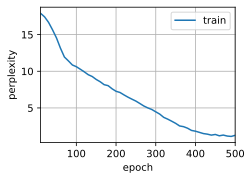

In [5]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_lstm_params,
                            init_lstm_state, lstm)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

## 简明的实施

使用高级 API，我们可以直接实例化 `LSTM` 模型。这封装了我们在上面明确说明的所有配置详细信息。代码要快得多，因为它使用编译的运算符而不是 Python 来处理我们之前详细说明的许多细节。


In [6]:
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens)
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

perplexity 1.0, 280876.3 tokens/sec on cuda:0
time traveller with a slight accession ofcheerfulness really thi


travelleryou can show black is white by argument said filby


lstM 是具有非平凡状态控制的原型潜在变量自回归模型。多年来，已经提出了许多变体，例如多层、剩余连接、不同类型的正则化。但是，由于序列的长距离依赖，训练 lstM 和其他序列模型（例如 GRU）的成本相当高。稍后我们将会遇到在某些情况下可以使用的替代模型，例如变形金刚。

## 摘要

* LSTM 有三种类型的门：输入门、忘记门和控制信息流的输出门。
* LSTM 的隐藏层输出包括隐藏状态和内存单元格。只有隐藏状态才会传递到输出层。记忆细胞完全是内部的。
* lstM 可以缓解渐变的消失和爆炸。

## 练习

1. 调整超参数并分析它们对运行时间、困惑和输出序列的影响。
1. 你需要如何更改模型以生成正确的单词而不是字符序列？
1. 比较给定隐藏维度的 gRU、LSTM 和常规 RNN 的计算成本。特别注意培训和推理成本。
1. 由于候选记忆单元通过使用 $\tanh$ 函数确保值范围在 $-1$ 和 $1$ 之间，为什么隐藏状态需要再次使用 $\tanh$ 函数来确保输出值范围在 $-1$ 和 $1$ 之间？
1. 实施 LSTM 模型进行时间序列预测，而不是字符序列预测。


[Discussions](https://discuss.d2l.ai/t/1057)
